<h1 style="color: red;  text-align: center;">Classification d’émotions à partir de texte</h1>


*****************

**Objectif:**

Construire un modèle deep learning pour la reconnaissance et la classification des émotions à partir des Tweets et posts sur les réseaux sociaux.

**Dataset:** Nous allons utiliser un dataset disponible sur Kaggle, intitulé Emotions Dataset for NLP. Le dataset contient des phrases courtes et chaque phrase est annotée par une des six émotions principales : joie, tristesse, colère, peur, amour ou surprise.

Le dataset est composé de 16 000 exemples pour l'entraînement et 2 000 pour le test et aussi 2000 pour la validation.

### Chargement et préparation du dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

# --- 1. Charger les fichiers .txt ---
datasetPath = r"D:\Projects\EmotionsFromText\DataSet"
train_df = pd.read_csv(datasetPath + "/train.txt", sep = ";", names = ["text","label"])
test_df = pd.read_csv(datasetPath + "/test.txt", sep = ";", names = ["text","label"])

In [3]:
print("train size = ", train_df.size)
print("test size = ", test_df.size)

train size =  32000
test size =  4000


In [4]:
train_df

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [6]:
train_df["label"].value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

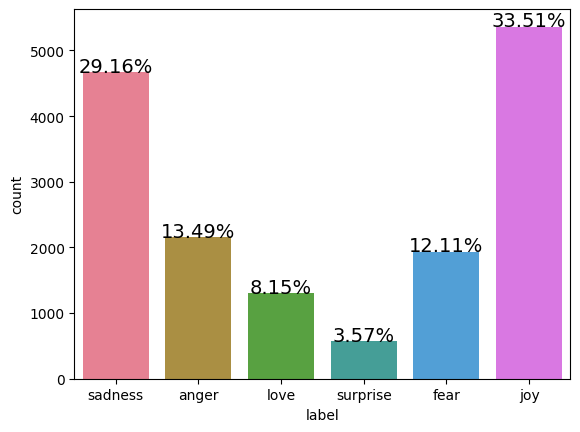

In [7]:
import seaborn as sb
s = sb.countplot(x = 'label',data = train_df,palette='husl')
for p in s.patches:
    height = p.get_height()
    s.text(p.get_x()+p.get_width()/2.,height+3,"{:1.2f}%".format(height/len(train_df)*100),ha="center",fontsize=14)

In [8]:
import re
#----- 3️- Nettoyage du texte -------

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# --- 2. Encodage des étiquettes ---
le = LabelEncoder()
# Etiquettes du dataset d'entrainement
y_train = to_categorical(le.fit_transform(train_df['label']))

# Etiquettes du dataset de test
y_test = to_categorical(le.transform(test_df['label']))

In [10]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], shape=(16000, 6))

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

# --- 3. Tokenisation
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

tokenizer.fit_on_texts(train_df['text'])

X_train = tokenizer.texts_to_sequences(train_df['text'])

X_test = tokenizer.texts_to_sequences(test_df['text'])

In [12]:
print ("Texte brut: ", train_df['text'][50])
print("\n")
print("Texte aprés Tokenization: ", X_train[50])

Texte brut:  i need to feel the dough to make sure its just perfect


Texte aprés Tokenization:  [2, 105, 5, 3, 6, 7419, 5, 80, 158, 79, 32, 356]


In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#  --- Padding ---
X_train = pad_sequences(X_train, maxlen=50)
X_test = pad_sequences(X_test, maxlen=50)

In [14]:
print(X_train[50])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    2  105    5    3
    6 7419    5   80  158   79   32  356]


### Conception du modéle de classification

*****

#### 1- LSTM Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=10000, output_dim=128, input_length=50))
model_lstm.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_lstm.add(LSTM(64, dropout=0.3))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(y_train.shape[1], activation='softmax'))

In [16]:
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.3188 - loss: 1.6311 - val_accuracy: 0.3525 - val_loss: 1.5644
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.3664 - loss: 1.5109 - val_accuracy: 0.5290 - val_loss: 1.2110
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.6526 - loss: 0.9349 - val_accuracy: 0.7440 - val_loss: 0.7599
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.8124 - loss: 0.5587 - val_accuracy: 0.8565 - val_loss: 0.4687
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.8963 - loss: 0.3421 - val_accuracy: 0.8665 - val_loss: 0.4094
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.9273 - loss: 0.2500 - val_accuracy: 0.8830 - val_loss: 0.3703
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9408 - loss: 0.1988 - val_accuracy: 0.8855 - val_loss: 0.3441
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.9528 - loss: 0.1618 - val_accu

In [17]:
loss, acc = model_lstm.evaluate(X_test, y_test)
print(f"LSTM - Test Accuracy: {acc*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8925 - loss: 0.3667
LSTM - Test Accuracy: 89.25%


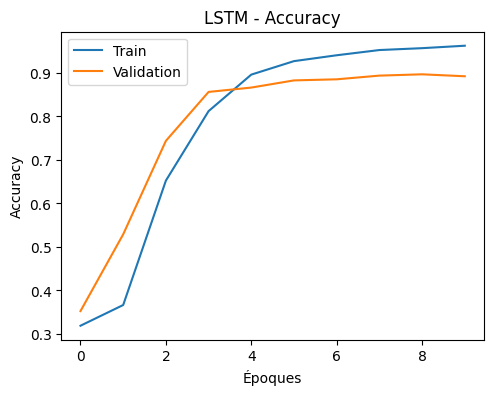

In [18]:
import matplotlib.pyplot as plt

# Courbes Accuracy per Epochs
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_lstm.history['accuracy'], label='Train')
plt.plot(history_lstm.history['val_accuracy'], label='Validation')
plt.title('LSTM - Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()


#### 2- GRU Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional

model_gru = Sequential()
model_gru.add(Embedding(input_dim=10000, output_dim=128, input_length=50))
model_gru.add(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_gru.add(GRU(64, dropout=0.3))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(y_train.shape[1], activation='softmax'))

In [20]:
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.3294 - loss: 1.6153 - val_accuracy: 0.4235 - val_loss: 1.4587
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.5676 - loss: 1.1390 - val_accuracy: 0.6890 - val_loss: 0.8660
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.7726 - loss: 0.6458 - val_accuracy: 0.8485 - val_loss: 0.4638
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.8777 - loss: 0.3690 - val_accuracy: 0.8820 - val_loss: 0.3304
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.9118 - loss: 0.2486 - val_accuracy: 0.8940 - val_loss: 0.2738
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.9312 - loss: 0.1979 - val_accuracy: 0.9050 - val_loss: 0.2700
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.9460 - loss: 0.1605 - val_accuracy: 0.9120 - val_loss: 0.2829
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.9541 - loss: 0.1319 - val_accu

In [21]:
loss, acc = model_gru.evaluate(X_test, y_test)
print(f"GRU - Test Accuracy: {acc*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9135 - loss: 0.2836
GRU - Test Accuracy: 91.35%


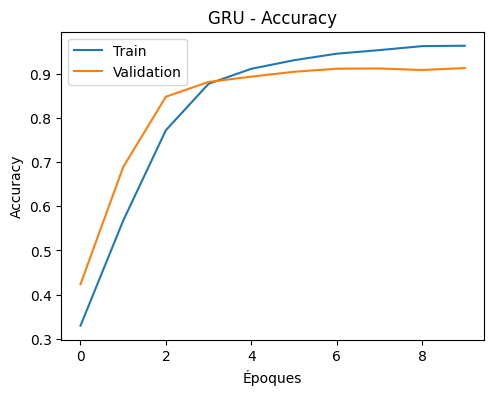

In [22]:
import matplotlib.pyplot as plt

# Courbes Accuracy per Epochs
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_gru.history['accuracy'], label='Train')
plt.plot(history_gru.history['val_accuracy'], label='Validation')
plt.title('GRU - Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()

### Analyse de la performance des modèles
***********

**1. Modèle LSTM**

Performance finale (Epoch 10) :

        Précision d'entraînement : 96.28%
        Performance sur l'ensemble de test - Accuracy : 89.25%
**2. Modèle GRU**

Performance finale (Epoch 10) :

    Précision d'entraînement : 96.41%
    Performance sur l'ensemble de test - Accuracy : 91.35%

**Conclusion**

Sur cet ensemble de données et avec les architectures testées, le modèle GRU (91.35% de précision) est plus performant que le modèle LSTM (89.25% de précision) pour la tâche de classification des émotions.


### Sauvegarder le modèle

In [23]:
# Sérialisation  
model_gru.save("EmotionsFromText_model_gru.h5")